In [ ]:
import numpy as np
import pandas as pd

import seaborn as sns
import re
import os
import sys

import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import rcParams


from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from sklearn.preprocessing import LabelEncoder

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score



In [52]:
df_mental = pd.read_csv('Combined Data.csv')

In [53]:
# verify that the data is correct
print(df_mental.head())


   Unnamed: 0                                          statement   status
0           0                                         oh my gosh  Anxiety
1           1  trouble sleeping, confused mind, restless hear...  Anxiety
2           2  All wrong, back off dear, forward doubt. Stay ...  Anxiety
3           3  I've shifted my focus to something else but I'...  Anxiety
4           4  I'm restless and restless, it's been a month n...  Anxiety


In [54]:
df_mental.isnull().sum()


Unnamed: 0      0
statement     362
status          0
dtype: int64

In [55]:
df_mental = df_mental.dropna()

In [56]:
df_mental.duplicated().sum()

0

In [57]:
df_mental.shape

(52681, 3)

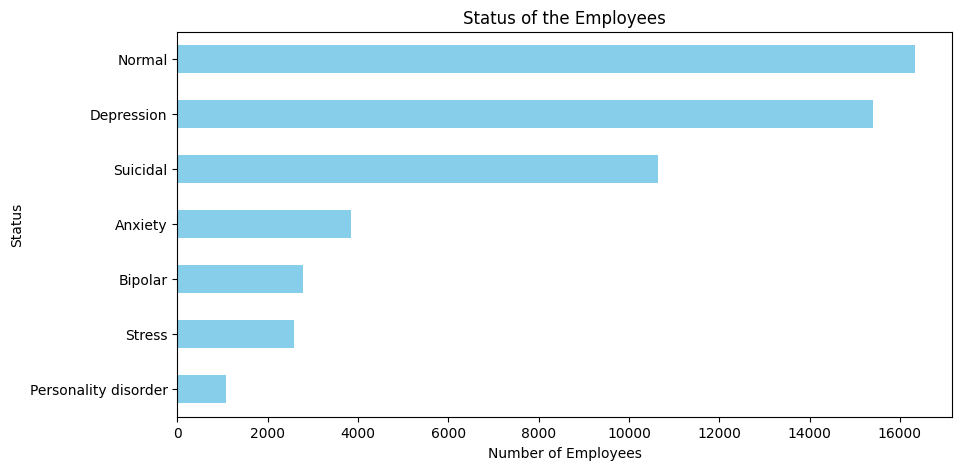

In [58]:
df_mental['status'].value_counts().sort_values().plot(kind='barh', color='skyblue',figsize=(10,5))
plt.title('Status of the Employees')
plt.xlabel('Number of Employees')
plt.ylabel('Status')
plt.show()

In [59]:
df_mental['statement'].head(5)

0                                           oh my gosh
1    trouble sleeping, confused mind, restless hear...
2    All wrong, back off dear, forward doubt. Stay ...
3    I've shifted my focus to something else but I'...
4    I'm restless and restless, it's been a month n...
Name: statement, dtype: object

In [60]:
# remove the special characters
df_mental['statement'] = df_mental['statement'].str.replace('[^a-zA-Z]', ' ')
# remove stopwords
from nltk.corpus import stopwords
stop = stopwords.words('english')
df_mental['statement'] = df_mental['statement'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [61]:
# convert the text to lowercase
df_mental['statement'] = df_mental['statement'].apply(lambda x: x.lower())
# remove the short words
df_mental['statement'] = df_mental['statement'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))
# removing the extra spaces and leading/trailing spaces, and punctuations
df_mental['statement'] = df_mental['statement'].apply(lambda x: re.sub(r'\s+', ' ', x))
df_mental['statement'] = df_mental['statement'].apply(lambda x: x.strip())
df_mental['statement'] = df_mental['statement'].apply(lambda x: re.sub(r'[^\w\s]','',x))

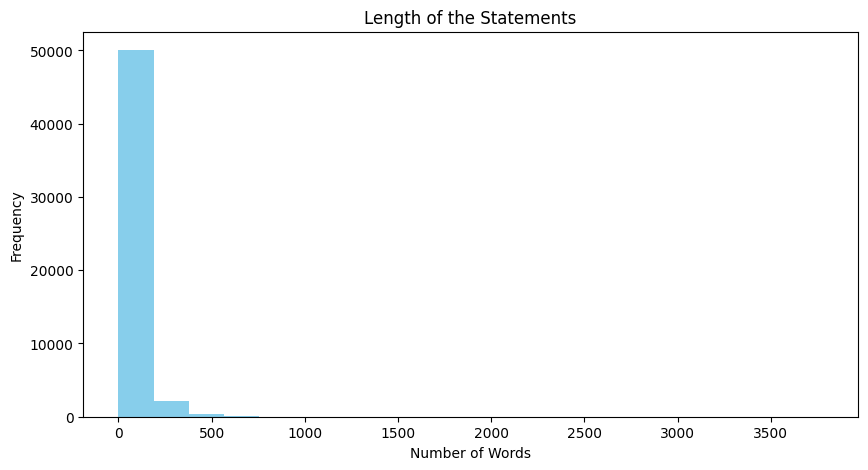

In [62]:
# plot by the number of words
df_mental['length'] = df_mental['statement'].apply(lambda x: len(x.split()))
df_mental['length'].plot(kind='hist',bins=20, color='skyblue', figsize=(10,5))
plt.title('Length of the Statements')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

In [63]:
# truncate the statement to 100 words
df_mental['statement'] = df_mental['statement'].apply(lambda x: ' '.join(x.split()[:100]))

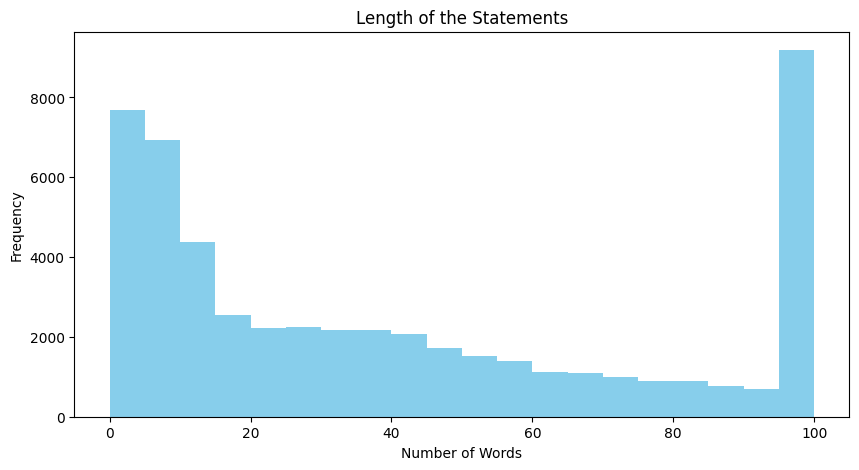

In [64]:
# plot by the number of words
df_mental['length'] = df_mental['statement'].apply(lambda x: len(x.split()))
df_mental['length'].plot(kind='hist',bins=20, color='skyblue', figsize=(10,5))
plt.title('Length of the Statements')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

In [65]:
index_del = list(df_mental[df_mental['length']<3].index)
df_mental = df_mental.drop(index_del)
df_mental.shape

(49508, 4)

In [66]:
# lemmitization
lemmatizer = WordNetLemmatizer()
df_mental['statement'] = df_mental['statement'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))


In [67]:
# stemming
stemmer = PorterStemmer()
df_mental['statement'] = df_mental['statement'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))
df_mental['statement'].head(5)

1     troubl sleep confus mind restless heart all tune
2    all wrong back dear forward doubt stay restles...
3             ive shift focu someth els im still worri
4         im restless restless month now boy what mean
5       everi break must nervou like someth wrong heck
Name: statement, dtype: object

In [68]:
df_mental

,Unnamed: 0,statement,status,length
1,1,troubl sleep confus mind restless heart all tune,Anxiety,8
2,2,all wrong back dear forward doubt stay restles...,Anxiety,10
3,3,ive shift focu someth els im still worri,Anxiety,8
4,4,im restless restless month now boy what mean,Anxiety,8
5,5,everi break must nervou like someth wrong heck,Anxiety,8
...,...,...,...,...
53038,53038,nobodi take serious ive 24m dealt depressionan...,Anxiety,100
53039,53039,selfish feel good like belong world think ever...,Anxiety,100
53040,53040,way sleep better cant sleep night med help,Anxiety,8
53041,53041,public speak tip hi all give present work next...,Anxiety,43


In [69]:
#df_mental['status'] = df_mental['status'].apply(lambda x: 0 if x=='Normal' else 1)

In [70]:
df_mental['status'].value_counts()

status
Depression              15314
Normal                  13358
Suicidal                10617
Anxiety                  3780
Bipolar                  2777
Stress                   2585
Personality disorder     1077
Name: count, dtype: int64

In [ ]:
# count vectorizer
#cv = CountVectorizer(max_features=2000, ngram_range=(1,2))
cv = CountVectorizer(max_features=1000, ngram_range=(1,2))
# tfidf
#cv = TfidfVectorizer(max_features=2000, ngram_range=(1,2))
# convert the text to vectors
df_mental['statement'] = df_mental['statement'].astype(str)
X = cv.fit_transform(df_mental['statement']).toarray()
y = df_mental['status']


/home/wagner/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/wagner/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


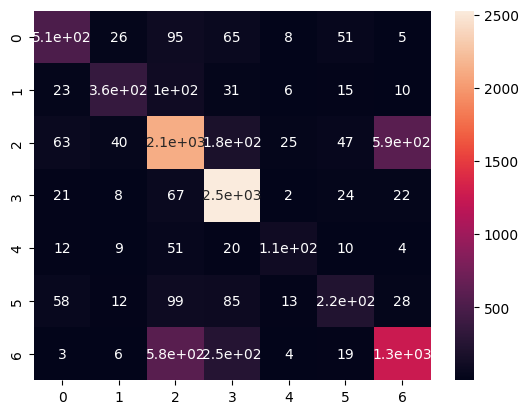

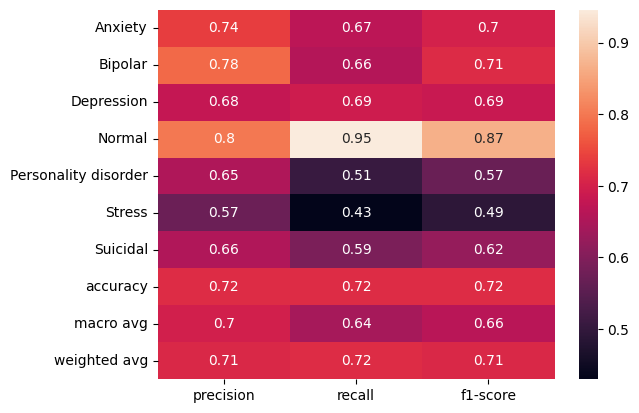

[[ 506   26   95   65    8   51    5]
 [  23  365  105   31    6   15   10]
 [  63   40 2115  180   25   47  593]
 [  21    8   67 2528    2   24   22]
 [  12    9   51   20  109   10    4]
 [  58   12   99   85   13  222   28]
 [   3    6  580  254    4   19 1258]]
0.7173298323570996
0.9222483666760157


In [ ]:
# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    stratify=y, random_state=42)
# feature scaling
sc = MinMaxScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
# train the model
#model = MultinomialNB()
# logistic regression
model = LogisticRegression(penalty='l2', C=10.1,l1_ratio=0.5)
# model decision tree
#model = DecisionTreeClassifier()
# xgbost
#model = XGBClassifier(n_estimators=10, learning_rate=0.05)
model.fit(X_train, y_train)
# predict the model
y_pred = model.predict(X_test)
# evaluate the model
cm = confusion_matrix(y_test, y_pred)
# print the confusion matrix as heatmap
sns.heatmap(cm, annot=True)
plt.show()
# do the same for classification report as heatmap
# transform y_test to original labels
#y_test = le.inverse_transform(y_test)
#y_pred = le.inverse_transform(y_pred)
cr = classification_report(y_test, y_pred, output_dict=True)
sns.heatmap(pd.DataFrame(cr).iloc[:-1, :].T, annot=True)
plt.show()

print(cm)
print(accuracy_score(y_test, y_pred))
# print auc score
#y_pred_proba = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)
print(roc_auc_score(y_test, y_pred_proba, multi_class='ovo'))


In [ ]:
# cloud word
from wordcloud import WordCloud
wc = WordCloud(width=800, height=400, max_words=200).generate(' '.join(df_mental['statement']))
plt.figure(figsize=(10,10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

ValueError: Only supported for TrueType fonts